In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('crypto-markets.csv.zip', parse_dates=['date'], index_col='date', date_parser=dateparse)
df.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [3]:
df.tail()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2018-01-02,ocow,OCOW,OCOW,1516,0.000014,0.000030,0.000013,0.000015,733,0,0.1176,0.0
2018-01-03,ocow,OCOW,OCOW,1516,0.000015,0.000031,0.000015,0.000015,1200,0,0.0000,0.0
2018-01-04,ocow,OCOW,OCOW,1516,0.000015,0.000031,0.000015,0.000030,5375,0,0.9375,0.0
2018-01-05,ocow,OCOW,OCOW,1516,0.000030,0.000032,0.000016,0.000017,1922,0,0.0625,0.0
2018-01-06,ocow,OCOW,OCOW,1516,0.000017,0.000017,0.000016,0.000017,1884,0,1.0000,0.0


In [4]:
# Extract the bitcoin data only
btc=df[df['symbol']=='BTC']
# Drop some columns
btc.drop(['slug', 'volume','symbol','name','ranknow','market', 'close_ratio', 'spread'],axis=1,inplace=True) 

In [5]:
btc.head()

,open,high,low,close
date,,,,
2013-04-28,135.30,135.98,132.10,134.21
2013-04-29,134.44,147.49,134.00,144.54
2013-04-30,144.00,146.93,134.05,139.00
2013-05-01,139.00,139.89,107.72,116.99
2013-05-02,116.38,125.60,92.28,105.21


In [6]:
# Lets take just the last year 
#btc = btc.loc['2017']
#btc.shape

In [7]:
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()

Stationarity check and Seasonal decomposition 

Dickey–Fuller test: p=0.998818


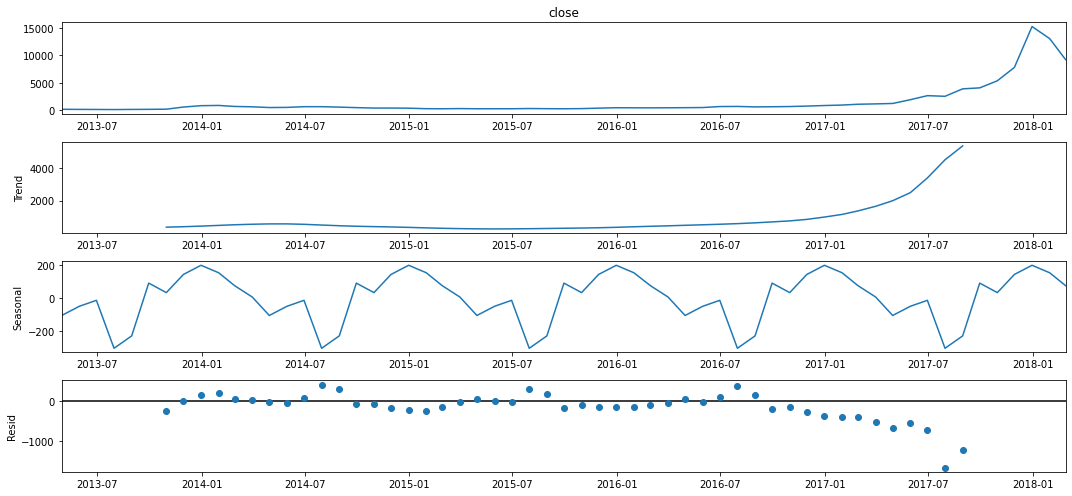

In [8]:
#seasonal_decompose(btc_month.close, freq=12).plot()
seasonal_decompose(btc_month.close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close)[1])
plt.show()

The p-value indicates that series is not stationary with 99.88% confidence.

In [9]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.513639


The p-value indicates that series is still not stationary.

In [10]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.666118


The p-value indicates that series is still not stationary

In [11]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.017880


The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

Dickey–Fuller test: p=0.002295


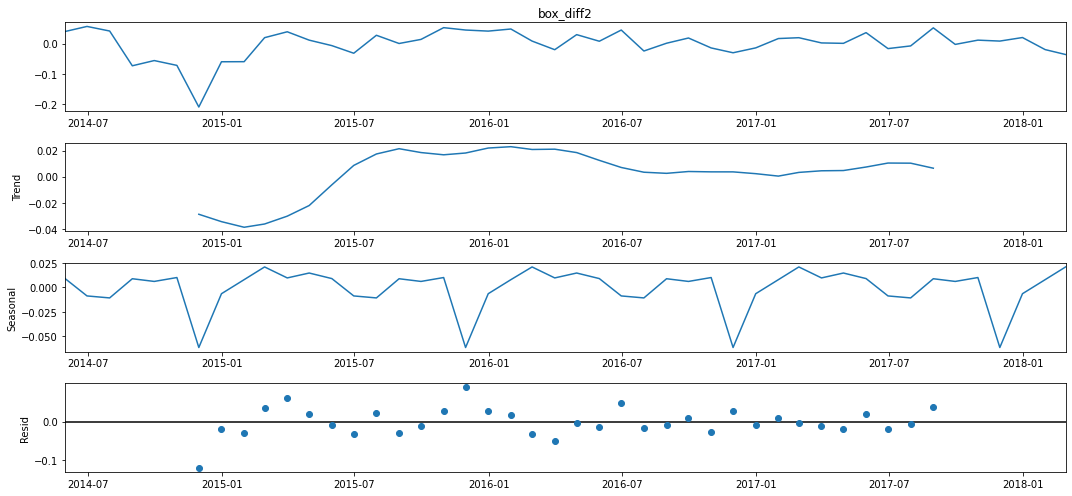

In [12]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

plt.show()

The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

# Autocorrelation 

Autocorrelation is the correlation of a time series with the same time series lagged. It summarizes the strength of a relationship with an observation in a time series with observations at prior time steps.

We create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals.

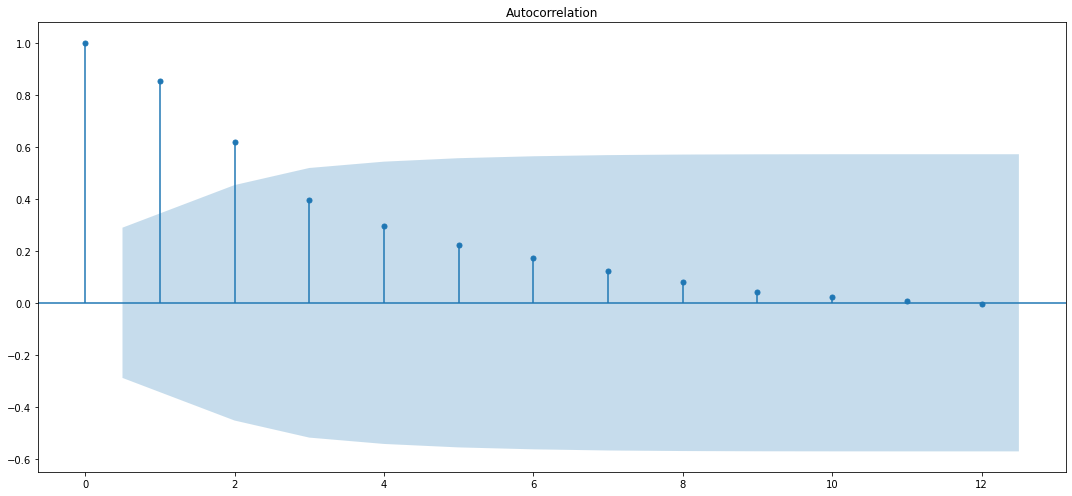

In [13]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

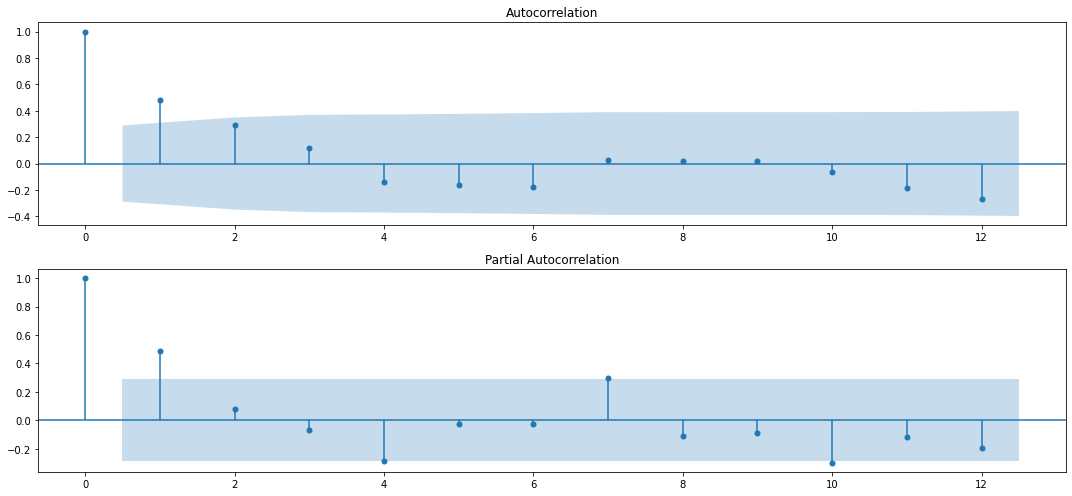

In [14]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

# ARIMA Model

p - the number of lag observations to include in the model, or lag order. (AR)
d - the number of times that the raw observations are differenced, or the degree of differencing. (I)
q - the size of the moving average window, also called the order of moving average.(MA)

In [15]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [16]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0) -221.187837
1     (0, 1) -220.803378
4     (1, 1) -219.227475
6     (2, 0) -219.218002
2     (0, 2) -219.002799


In [17]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   59
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 112.594
Date:                Fri, 19 Nov 2021   AIC                           -221.188
Time:                        10:21:05   BIC                           -217.067
Sample:                    04-30-2013   HQIC                          -219.583
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3737      0.151      2.471      0.013       0.077       0.670
sigma2         0.0012      0.000     11.243      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.02   Jarque-

In [18]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.005647


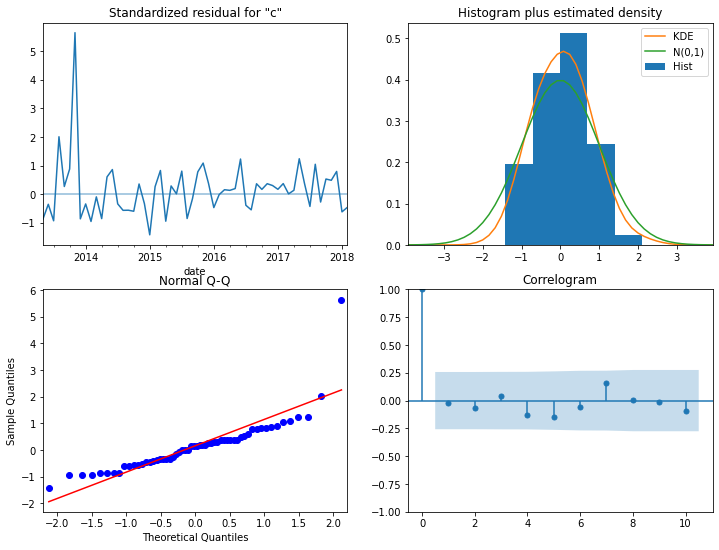

In [19]:
best_model.plot_diagnostics(figsize=(12, 9))
plt.show()


In [20]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

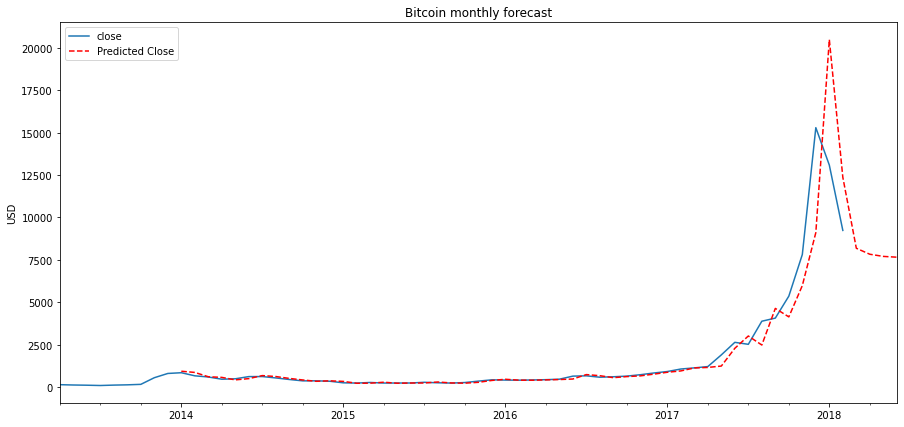

In [21]:
# Prediction
btc_month_pred = btc_month[['close']]
#date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), 
#             datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31),
#             datetime(2018, 11, 30), datetime(2018, 12, 31)]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime(2018, 6, 30)), lmbda)


plt.figure(figsize=(15,7))
btc_month_pred.close.plot()
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()


In [22]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [23]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
21  (1, 0, 1, 1) -194.119421
49  (2, 2, 0, 1) -193.932706
19  (1, 0, 0, 1) -193.712508
9   (0, 1, 1, 1) -193.242255
7   (0, 1, 0, 1) -193.211698
                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                   59
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 101.060
Date:                             Fri, 19 Nov 2021   AIC                           -194.119
Time:                                     10:21:24   BIC                           -186.163
Sample:                                 04-30-2013   HQIC                          -191.051
                                      - 02-28-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

In [24]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.072228


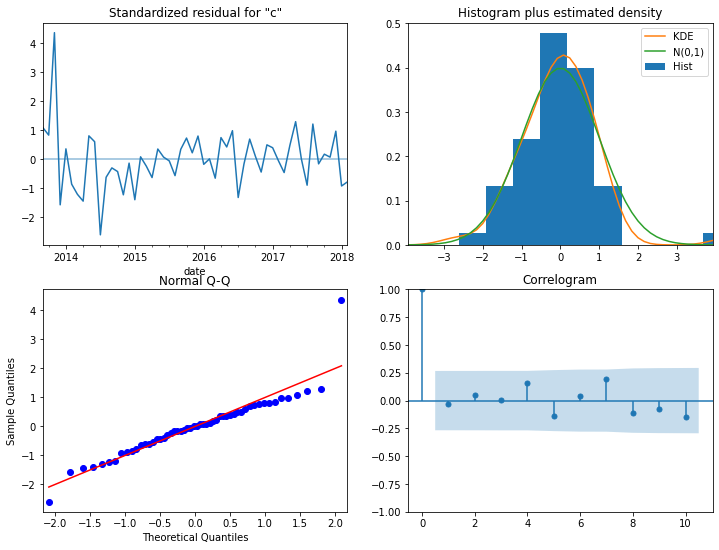

In [25]:
best_model.plot_diagnostics(figsize=(12, 9))
plt.show()

Dickey–Fuller test:: p=0.072228


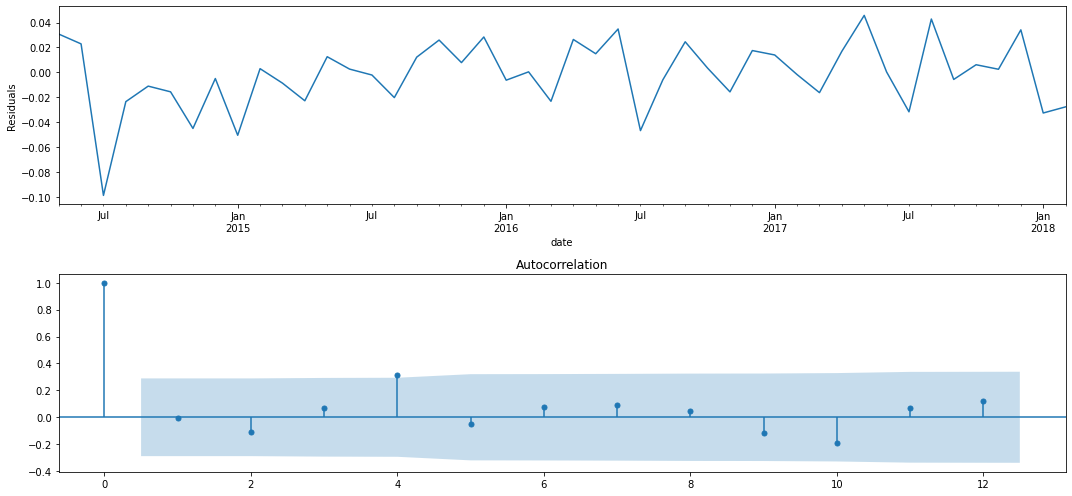

In [26]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

# Prediction

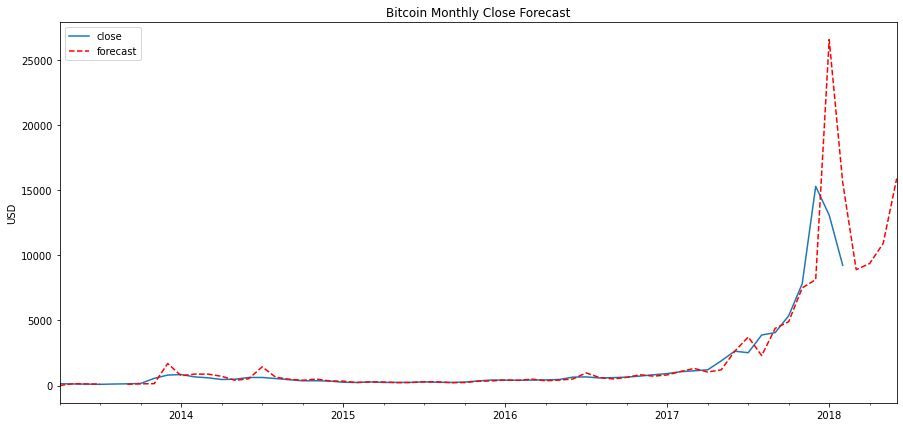

In [27]:
# Prediction
btc_month2 = btc_month[['close']]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month2 = pd.concat([btc_month2, future])

btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
btc_month2.close.plot()
btc_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('bitcoin_monthly_forecast.png')
plt.show()

Validation 

# ANN

In [28]:
y_forecasted = btc_month2.forecast
y_truth = btc_month2['2015-01-01':'2016-01-01'].close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth)*2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 0.91


In [29]:
X = df.drop(columns=['slug', 'volume','symbol','name','ranknow','market', 'close_ratio', 'spread'])
y = df['close']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [30]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0.5,0.7))
X_train = sc.fit_transform(x_train)
X_test = sc.fit_transform(x_test)

In [31]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(561732, 4) (140434, 4)
(561732,) (140434,)


In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def train(model, x_train, y_train):
    # train the model
    model.fit(x_train, y_train)
    
    # predict the training set
    pred = model.predict(x_test)
    
    # perform cross-validation
    cv_score = cross_val_score(model, x_test, y_test, scoring='neg_mean_squared_error', cv=5)
    cv_score = np.abs(np.mean(cv_score))
    
    mse = mean_squared_error(y_test,pred)

    mape = np.mean(np.abs((y_test - pred)/y_test)) * 100
    
    print("******* Model Report *******")
    print("Mean Squared Error:",mse)
    #print("Root Mean Squared Error:",math.sqrt(mse))
    print("Cross Val Score:", cv_score)
    print("Mean absolute percentage error:", mape)

In [33]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=False)
train(model, x_train,y_train)

******* Model Report *******
Mean Squared Error: 3.840677408652156e-20
Cross Val Score: 2.4267903918691903e-22
Mean absolute percentage error: inf


In [34]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [35]:
model_nn = Sequential()

In [36]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(561732, 4) (140434, 4)
(561732,) (140434,)


In [37]:
model_nn.add(Dense(units = 32,kernel_initializer = 'uniform',activation = 'relu'))
model_nn.add(Dense(units = 28,kernel_initializer = 'uniform',activation = 'relu'))
model_nn.add(Dense(units = 16,kernel_initializer = 'uniform',activation = 'relu'))
model_nn.add(Dense(units = 8,kernel_initializer = 'uniform',activation = 'relu'))
model_nn.add(Dense(units = 1,kernel_initializer = 'uniform',activation = 'linear'))

model_nn.compile(loss='mse',optimizer = 'adam',metrics=['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error'])

In [38]:
model_nn.fit(x_train,y_train,epochs=50)

Epoch 1/50
17555/17555 [==============================] - 30s 2ms/step - loss: 14015587.0000 - mean_squared_error: 14015587.0000 - mean_absolute_error: 67.5830 - mean_absolute_percentage_error: 4183746.5000
Epoch 2/50
17555/17555 [==============================] - 28s 2ms/step - loss: 8205195.0000 - mean_squared_error: 8205195.0000 - mean_absolute_error: 48.1262 - mean_absolute_percentage_error: 10734128.0000
Epoch 3/50
17555/17555 [==============================] - 27s 2ms/step - loss: 7069144.0000 - mean_squared_error: 7069144.0000 - mean_absolute_error: 38.2898 - mean_absolute_percentage_error: 7753915.0000
Epoch 4/50
17555/17555 [==============================] - 26s 2ms/step - loss: 6233730.5000 - mean_squared_error: 6233730.5000 - mean_absolute_error: 37.0288 - mean_absolute_percentage_error: 5393281.5000
Epoch 5/50
17555/17555 [==============================] - 27s 2ms/step - loss: 5664492.5000 - mean_squared_error: 5664492.5000 - mean_absolute_error: 36.4136 - mean_absolute_per

In [39]:
pred = model_nn.predict(x_test)
pred

array([[0.5147209 ],
       [0.51470757],
       [0.5155029 ],
       ...,
       [0.5159259 ],
       [0.5174141 ],
       [0.5145221 ]], dtype=float32)

In [40]:
pred = pred.flatten()

In [55]:
mse = mean_squared_error(y_test,pred)

mape = np.mean(np.abs((y_test - pred)/y_test))

print("******* Model Report *******")
print("Mean Squared Error:",mse)
print("Mean absolute percentage error:", mape)

******* Model Report *******
Mean Squared Error: 0.9502679388163695
Mean absolute percentage error: inf


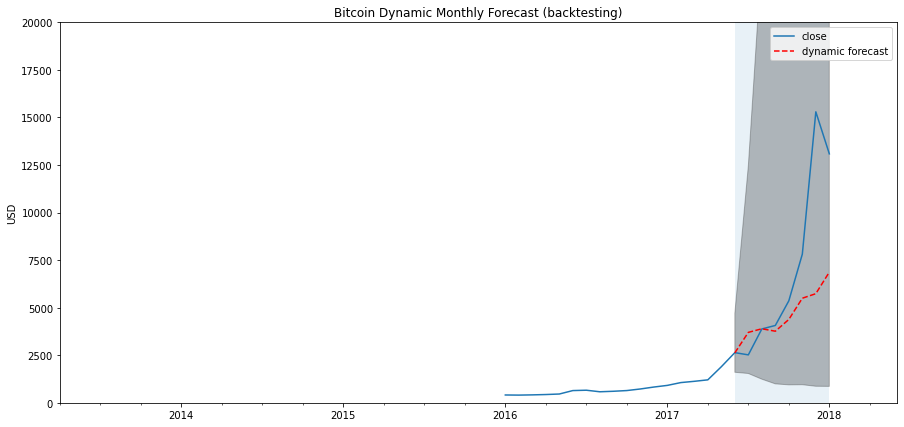

In [42]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2017-06-30')
t2 = pd.to_datetime('2018-01-31')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.figure(figsize=(15,7))
plt.ylim((0,20000))

btc_month2.close['2016':'2018-01'].plot(label='close')
btc_month2.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast')

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()